In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_ViT = pd.read_csv("/content/pca_training_ViT_features.csv")
df_masked_ViT = pd.read_csv("/content/pca_masked_train_features_ViT.csv")
df_ssf_ViT = pd.read_csv("/content/pca_ssf_training_ViT_features.csv")

df_swin = pd.read_csv("/content/pca_training_df_swin_features.csv")
df_masked_swin = pd.read_csv("/content/pca_masked_training_df_swin_features (1).csv")
df_ssf_swin = pd.read_csv("/content/pca_ssf_training_df_swin_features.csv")

In [ ]:
df_ViT.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,label
0,-62.993640,-6.435823,-72.974250,-30.888140,38.091770,45.529728,19.459692,-16.601875,22.433052,21.066920,...,11.214919,-12.480081,35.912440,-22.439034,8.692132,-5.031202,-9.249351,14.105970,7.315361,0.0
1,4.546556,-8.628555,-100.561260,30.292988,-28.782679,11.955135,31.410450,10.733553,26.617966,-26.909920,...,-6.018917,1.130894,9.401999,-15.776917,18.007797,27.179628,21.116829,-9.941970,-11.002527,0.0
2,13.969452,-17.141022,-19.553200,1.156259,-28.814960,-25.918043,-37.005780,11.051662,32.873120,6.366947,...,25.998549,-2.996984,0.566189,-2.361527,-8.048707,-17.970509,-7.395420,-11.300818,9.843273,1.0
3,-5.185709,-22.808168,47.287680,69.650720,-13.504474,2.362310,9.001296,-10.672569,-45.572872,-5.504066,...,-8.564558,-29.234636,11.816242,-4.415619,-3.457963,-29.062197,23.938118,50.036930,-1.056281,0.0
4,10.365436,23.285437,2.638179,27.278723,5.042839,12.615994,-20.297300,14.220032,24.785473,15.411177,...,-16.907549,20.654270,-3.827493,21.799318,29.324306,4.020783,-8.024049,-8.227302,-2.499687,0.0


In [ ]:
df_swin.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,label
0,5.671144,-0.256850,-10.263258,1.785450,3.192679,10.115611,0.835512,-0.242868,-8.432805,-2.704746,...,2.398228,2.488565,1.960874,-0.932783,0.064400,0.528200,-0.504794,-0.995343,-0.416345,0
1,1.250275,9.008254,-4.718751,-0.522621,0.558036,7.847922,-5.748904,7.703976,5.919034,-2.779085,...,-0.250307,-0.009048,0.470698,1.851317,0.258300,-0.072829,-0.188386,0.285172,0.631876,0
2,-6.030702,7.580019,-6.813349,-14.154367,-0.284595,-4.320102,6.701635,-0.964254,-4.665266,6.047037,...,-0.055158,0.458141,-2.613234,-1.087826,0.657495,0.409402,0.184641,-0.404065,0.169318,1
3,8.599432,-1.925988,11.327355,13.854836,-1.886545,4.610267,3.081134,-9.492836,3.267789,4.734504,...,-1.395266,-3.508160,-0.956622,-1.539444,-0.502616,-0.285578,-0.068862,0.552773,-1.003686,0
4,4.347176,-2.802915,-0.283337,-13.265371,3.437304,4.810991,-1.777408,2.257589,4.853016,7.095845,...,1.328995,-0.559796,-1.090826,-1.103152,-0.154332,-0.132334,0.054563,-0.385878,0.763556,0


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def tune_xgb_fast(df, label_col, n_trials=30):
    X = df.drop(columns=[label_col])
    y = df[label_col]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 3, 7),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "tree_method": "hist",
            "eval_metric": "logloss",
            "objective": "binary:logistic",
        }

        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_valid)
        acc = accuracy_score(y_valid, preds)

        return acc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best params:", study.best_params)
    print("Best accuracy:", study.best_value)

    # return best model
    best_model = XGBClassifier(
        **study.best_params,
        tree_method="hist",
        eval_metric="logloss",
        objective="binary:logistic",
    )
    best_model.fit(X_train, y_train)

    return best_model


In [ ]:
xgb_vit = tune_xgb_fast(df_ViT, "label")
xgb_vit_masked = tune_xgb_fast(df_masked_ViT, "label")
xgb_vit_ssf = tune_xgb_fast(df_ssf_ViT, "label")

xgb_swin = tune_xgb_fast(df_swin, "label")
xgb_swin_masked = tune_xgb_fast(df_masked_swin, "label")
xgb_swin_ssf = tune_xgb_fast(df_ssf_swin, "label")


[I 2025-12-02 20:49:20,073] A new study created in memory with name: no-name-fed5275b-289f-41cf-a9ff-25e4e3adb99c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:49:21,953] Trial 0 finished with value: 0.5322033898305085 and parameters: {'n_estimators': 324, 'learning_rate': 0.11773844565409478, 'max_depth': 5, 'subsample': 0.7834331801696547, 'colsample_bytree': 0.9930215494086132}. Best is trial 0 with value: 0.5322033898305085.
[I 2025-12-02 20:49:23,432] Trial 1 finished with value: 0.5525423728813559 and parameters: {'n_estimators': 338, 'learning_rate': 0.1968086714070363, 'max_depth': 7, 'subsample': 0.9194198501468307, 'colsample_bytree': 0.71506170678497}. Best is trial 1 with value: 0.5525423728813559.
[I 2025-12-02 20:49:25,310] Trial 2 finished with value: 0.5288135593220339 and parameters: {'n_estimators': 353, 'learning_rate': 0.1287889957643653, 'max_depth': 6, 'subsample': 0.8441535344029105, 'colsample_bytree': 0.8421145064748681}. Best is trial 1 with value: 0.5525423728813559.
[I 2025-12-02 20:49:28,774] Trial 3 finished with value: 0.5525423728813559 and parameters: {'n_estimators': 157, 'learning_rate': 0.1

[I 2025-12-02 20:50:07,784] A new study created in memory with name: no-name-b719b3d9-d8e8-4a86-bb39-642d3d12631f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:50:12,681] Trial 0 finished with value: 0.7016949152542373 and parameters: {'n_estimators': 326, 'learning_rate': 0.07366205788902468, 'max_depth': 7, 'subsample': 0.7464936616226286, 'colsample_bytree': 0.7753290212389967}. Best is trial 0 with value: 0.7016949152542373.
[I 2025-12-02 20:50:14,302] Trial 1 finished with value: 0.7084745762711865 and parameters: {'n_estimators': 319, 'learning_rate': 0.12719736609443202, 'max_depth': 7, 'subsample': 0.9338736288041052, 'colsample_bytree': 0.7419841205337645}. Best is trial 1 with value: 0.7084745762711865.
[I 2025-12-02 20:50:15,251] Trial 2 finished with value: 0.7254237288135593 and parameters: {'n_estimators': 245, 'learning_rate': 0.07859859941557659, 'max_depth': 4, 'subsample': 0.8702984193147026, 'colsample_bytree': 0.7879348562596927}. Best is trial 2 with value: 0.7254237288135593.
[I 2025-12-02 20:50:16,461] Trial 3 finished with value: 0.7220338983050848 and parameters: {'n_estimators': 196, 'learning_rate':

[I 2025-12-02 20:50:55,131] A new study created in memory with name: no-name-33b33094-f6a8-472f-85c0-adfb8895808d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:50:57,710] Trial 0 finished with value: 0.4576271186440678 and parameters: {'n_estimators': 294, 'learning_rate': 0.09720379350072562, 'max_depth': 7, 'subsample': 0.9528725753813733, 'colsample_bytree': 0.914876771142172}. Best is trial 0 with value: 0.4576271186440678.
[I 2025-12-02 20:51:00,531] Trial 1 finished with value: 0.45084745762711864 and parameters: {'n_estimators': 291, 'learning_rate': 0.07767106747190844, 'max_depth': 7, 'subsample': 0.8519159496005599, 'colsample_bytree': 0.9726223273417152}. Best is trial 0 with value: 0.4576271186440678.
[I 2025-12-02 20:51:01,904] Trial 2 finished with value: 0.48135593220338985 and parameters: {'n_estimators': 179, 'learning_rate': 0.1598152995231044, 'max_depth': 6, 'subsample': 0.7295255272535086, 'colsample_bytree': 0.9487343625187361}. Best is trial 2 with value: 0.48135593220338985.
[I 2025-12-02 20:51:08,497] Trial 3 finished with value: 0.43728813559322033 and parameters: {'n_estimators': 343, 'learning_rate

[I 2025-12-02 20:51:44,696] A new study created in memory with name: no-name-bc1fdb94-2b78-4322-bb8e-f424f61bd881


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:51:45,566] Trial 0 finished with value: 0.6169491525423729 and parameters: {'n_estimators': 323, 'learning_rate': 0.1329178307267743, 'max_depth': 3, 'subsample': 0.8248446820525243, 'colsample_bytree': 0.8718822890674941}. Best is trial 0 with value: 0.6169491525423729.
[I 2025-12-02 20:51:46,019] Trial 1 finished with value: 0.6135593220338983 and parameters: {'n_estimators': 164, 'learning_rate': 0.19615183467324193, 'max_depth': 3, 'subsample': 0.8518379886156819, 'colsample_bytree': 0.8787728828078567}. Best is trial 0 with value: 0.6169491525423729.
[I 2025-12-02 20:51:50,407] Trial 2 finished with value: 0.6237288135593221 and parameters: {'n_estimators': 270, 'learning_rate': 0.10233631191039637, 'max_depth': 5, 'subsample': 0.7080231780414806, 'colsample_bytree': 0.9641822602133358}. Best is trial 2 with value: 0.6237288135593221.
[I 2025-12-02 20:51:54,361] Trial 3 finished with value: 0.6169491525423729 and parameters: {'n_estimators': 299, 'learning_rate': 

[I 2025-12-02 20:52:38,391] A new study created in memory with name: no-name-4e25929a-9881-4704-9e33-61489bf19883


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:52:39,402] Trial 0 finished with value: 0.6983050847457627 and parameters: {'n_estimators': 259, 'learning_rate': 0.06445590593716856, 'max_depth': 4, 'subsample': 0.8998717057007581, 'colsample_bytree': 0.7755784964319603}. Best is trial 0 with value: 0.6983050847457627.
[I 2025-12-02 20:52:40,904] Trial 1 finished with value: 0.7186440677966102 and parameters: {'n_estimators': 339, 'learning_rate': 0.1585545151527599, 'max_depth': 7, 'subsample': 0.93380472996865, 'colsample_bytree': 0.8136838611977592}. Best is trial 1 with value: 0.7186440677966102.
[I 2025-12-02 20:52:42,423] Trial 2 finished with value: 0.7050847457627119 and parameters: {'n_estimators': 184, 'learning_rate': 0.09494605750751059, 'max_depth': 6, 'subsample': 0.9910133350582725, 'colsample_bytree': 0.9679419256532099}. Best is trial 1 with value: 0.7186440677966102.
[I 2025-12-02 20:52:45,824] Trial 3 finished with value: 0.711864406779661 and parameters: {'n_estimators': 275, 'learning_rate': 0.0

[I 2025-12-02 20:53:36,099] A new study created in memory with name: no-name-b7c8a1b9-d056-4c89-bf55-7d180db38261


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:53:37,574] Trial 0 finished with value: 0.5728813559322034 and parameters: {'n_estimators': 356, 'learning_rate': 0.1945753294620836, 'max_depth': 6, 'subsample': 0.8374940347235187, 'colsample_bytree': 0.7385136727444543}. Best is trial 0 with value: 0.5728813559322034.
[I 2025-12-02 20:53:41,194] Trial 1 finished with value: 0.5389830508474577 and parameters: {'n_estimators': 187, 'learning_rate': 0.0416747612759369, 'max_depth': 6, 'subsample': 0.9297987198781426, 'colsample_bytree': 0.8963625458847164}. Best is trial 0 with value: 0.5728813559322034.
[I 2025-12-02 20:53:45,256] Trial 2 finished with value: 0.5728813559322034 and parameters: {'n_estimators': 285, 'learning_rate': 0.026449157109240055, 'max_depth': 7, 'subsample': 0.8071801164327982, 'colsample_bytree': 0.831108627895919}. Best is trial 0 with value: 0.5728813559322034.
[I 2025-12-02 20:53:48,841] Trial 3 finished with value: 0.5966101694915255 and parameters: {'n_estimators': 395, 'learning_rate': 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_xgb_model(model, X_test, y_test):

    # predictions
    y_pred = model.predict(X_test)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Iceberg", "Vessel"],
                yticklabels=["Iceberg", "Vessel"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "confusion_matrix": cm
    }


[I 2025-12-02 20:57:38,229] A new study created in memory with name: no-name-718f2e78-917b-4747-8a74-c406c1611730


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 20:57:48,371] Trial 0 finished with value: 0.5694915254237288 and parameters: {'n_estimators': 308, 'learning_rate': 0.05364852846158069, 'max_depth': 4, 'subsample': 0.8667058215316608, 'colsample_bytree': 0.7227416898497104}. Best is trial 0 with value: 0.5694915254237288.
[I 2025-12-02 20:57:50,496] Trial 1 finished with value: 0.49491525423728816 and parameters: {'n_estimators': 162, 'learning_rate': 0.11439213084558401, 'max_depth': 5, 'subsample': 0.7293353940712971, 'colsample_bytree': 0.7732105603138839}. Best is trial 0 with value: 0.5694915254237288.
[I 2025-12-02 20:57:51,993] Trial 2 finished with value: 0.5322033898305085 and parameters: {'n_estimators': 311, 'learning_rate': 0.1892742475149445, 'max_depth': 6, 'subsample': 0.811090116425003, 'colsample_bytree': 0.8748637587706454}. Best is trial 0 with value: 0.5694915254237288.
[I 2025-12-02 20:57:55,236] Trial 3 finished with value: 0.559322033898305 and parameters: {'n_estimators': 350, 'learning_rate': 0

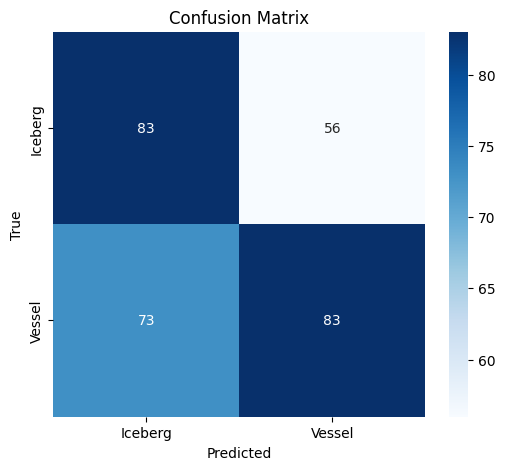

In [ ]:
best_model = tune_xgb_fast(df_ViT, "label")

X = df_ViT.drop(columns=["label"])
y = df_ViT["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)


[I 2025-12-02 21:14:43,022] A new study created in memory with name: no-name-fe201bfc-27dd-41c2-a1c1-83215bc0b0e0


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 21:14:44,186] Trial 0 finished with value: 0.7254237288135593 and parameters: {'n_estimators': 237, 'learning_rate': 0.10635864023506315, 'max_depth': 5, 'subsample': 0.7897413097759532, 'colsample_bytree': 0.7786490152889405}. Best is trial 0 with value: 0.7254237288135593.
[I 2025-12-02 21:14:45,505] Trial 1 finished with value: 0.7084745762711865 and parameters: {'n_estimators': 215, 'learning_rate': 0.08032921926259008, 'max_depth': 5, 'subsample': 0.8603003064183067, 'colsample_bytree': 0.9372764041697784}. Best is trial 0 with value: 0.7254237288135593.
[I 2025-12-02 21:14:46,165] Trial 2 finished with value: 0.6779661016949152 and parameters: {'n_estimators': 302, 'learning_rate': 0.03756009779383877, 'max_depth': 3, 'subsample': 0.936919882258163, 'colsample_bytree': 0.7690510054920726}. Best is trial 0 with value: 0.7254237288135593.
[I 2025-12-02 21:14:47,663] Trial 3 finished with value: 0.6915254237288135 and parameters: {'n_estimators': 395, 'learning_rate': 

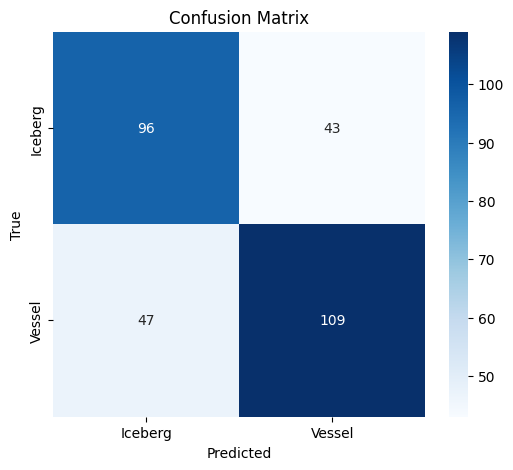

In [ ]:
best_model = tune_xgb_fast(df_masked_ViT, "label")

X = df_masked_ViT.drop(columns=["label"])
y = df_masked_ViT["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)


[I 2025-12-02 21:20:35,994] A new study created in memory with name: no-name-95464101-6f62-4022-9f4a-bb72eadf9a73


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 21:20:39,354] Trial 0 finished with value: 0.4745762711864407 and parameters: {'n_estimators': 368, 'learning_rate': 0.016803384838303233, 'max_depth': 3, 'subsample': 0.9117068325109874, 'colsample_bytree': 0.8038213090756641}. Best is trial 0 with value: 0.4745762711864407.
[I 2025-12-02 21:20:42,269] Trial 1 finished with value: 0.4745762711864407 and parameters: {'n_estimators': 167, 'learning_rate': 0.05447670196106384, 'max_depth': 5, 'subsample': 0.8109257878711076, 'colsample_bytree': 0.7671704772495502}. Best is trial 0 with value: 0.4745762711864407.
[I 2025-12-02 21:20:44,050] Trial 2 finished with value: 0.47796610169491527 and parameters: {'n_estimators': 386, 'learning_rate': 0.1670097772044286, 'max_depth': 6, 'subsample': 0.9660522156431359, 'colsample_bytree': 0.7964740694827058}. Best is trial 2 with value: 0.47796610169491527.
[I 2025-12-02 21:20:46,644] Trial 3 finished with value: 0.5220338983050847 and parameters: {'n_estimators': 323, 'learning_rate

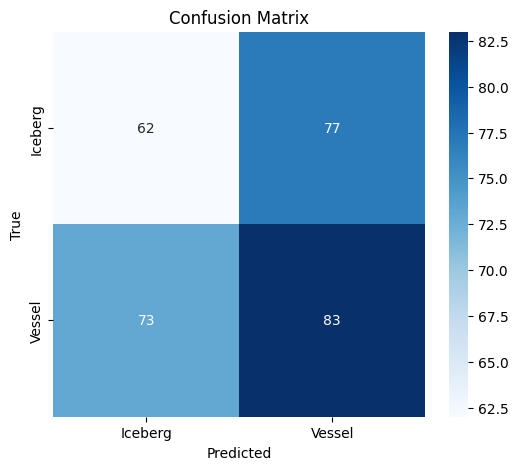

In [ ]:
best_model = tune_xgb_fast(df_ssf_ViT, "label")

X = df_ssf_ViT.drop(columns=["label"])
y = df_ssf_ViT["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)

[I 2025-12-02 21:23:10,733] A new study created in memory with name: no-name-bdcdf3d7-9be0-4ebf-9b36-11f260568d4d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 21:23:12,295] Trial 0 finished with value: 0.6101694915254238 and parameters: {'n_estimators': 335, 'learning_rate': 0.1318507067481547, 'max_depth': 3, 'subsample': 0.7590782360007456, 'colsample_bytree': 0.8106969165725795}. Best is trial 0 with value: 0.6101694915254238.
[I 2025-12-02 21:23:14,670] Trial 1 finished with value: 0.6237288135593221 and parameters: {'n_estimators': 386, 'learning_rate': 0.08155329062329468, 'max_depth': 6, 'subsample': 0.9182706453532783, 'colsample_bytree': 0.8133043431954979}. Best is trial 1 with value: 0.6237288135593221.
[I 2025-12-02 21:23:18,852] Trial 2 finished with value: 0.6135593220338983 and parameters: {'n_estimators': 317, 'learning_rate': 0.02186117624296569, 'max_depth': 4, 'subsample': 0.7119982431397086, 'colsample_bytree': 0.9863857146600414}. Best is trial 1 with value: 0.6237288135593221.
[I 2025-12-02 21:23:19,933] Trial 3 finished with value: 0.6101694915254238 and parameters: {'n_estimators': 335, 'learning_rate': 

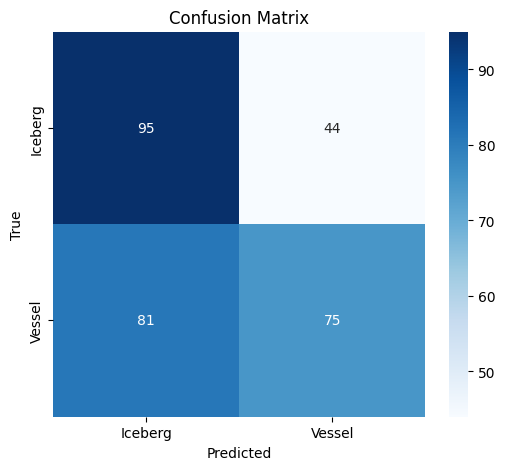

In [ ]:
best_model = tune_xgb_fast(df_swin, "label")

X = df_swin.drop(columns=["label"])
y = df_swin["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)

[I 2025-12-02 21:52:37,046] A new study created in memory with name: no-name-faae98b4-74ea-4428-8ff6-00a4077b9e42


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 21:52:45,554] Trial 0 finished with value: 0.7084745762711865 and parameters: {'n_estimators': 188, 'learning_rate': 0.181451633775878, 'max_depth': 4, 'subsample': 0.9790520208152287, 'colsample_bytree': 0.7751948611660273}. Best is trial 0 with value: 0.7084745762711865.
[I 2025-12-02 21:52:50,314] Trial 1 finished with value: 0.7084745762711865 and parameters: {'n_estimators': 320, 'learning_rate': 0.11024444050618763, 'max_depth': 7, 'subsample': 0.9379094092068863, 'colsample_bytree': 0.7533033730994618}. Best is trial 0 with value: 0.7084745762711865.
[I 2025-12-02 21:52:53,130] Trial 2 finished with value: 0.6983050847457627 and parameters: {'n_estimators': 352, 'learning_rate': 0.07761192431186259, 'max_depth': 3, 'subsample': 0.7476622954711388, 'colsample_bytree': 0.9012414462954284}. Best is trial 0 with value: 0.7084745762711865.
[I 2025-12-02 21:52:56,576] Trial 3 finished with value: 0.6915254237288135 and parameters: {'n_estimators': 269, 'learning_rate': 0

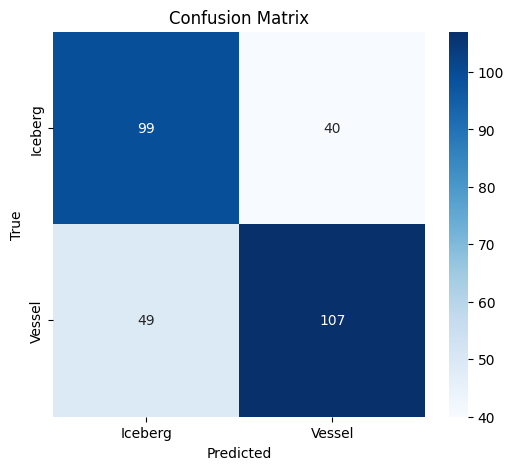

In [ ]:
best_model = tune_xgb_fast(df_masked_swin, "label")

X = df_masked_swin.drop(columns=["label"])
y = df_masked_swin["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)

[I 2025-12-02 21:56:18,918] A new study created in memory with name: no-name-4f64d827-6ab5-4344-a991-76957c844b0d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-02 21:56:23,302] Trial 0 finished with value: 0.5457627118644067 and parameters: {'n_estimators': 255, 'learning_rate': 0.15763778429310557, 'max_depth': 6, 'subsample': 0.9517601763387851, 'colsample_bytree': 0.7051190575596783}. Best is trial 0 with value: 0.5457627118644067.
[I 2025-12-02 21:56:24,439] Trial 1 finished with value: 0.5457627118644067 and parameters: {'n_estimators': 197, 'learning_rate': 0.1503265531877461, 'max_depth': 3, 'subsample': 0.843864862880233, 'colsample_bytree': 0.8435416184216216}. Best is trial 0 with value: 0.5457627118644067.
[I 2025-12-02 21:56:26,782] Trial 2 finished with value: 0.559322033898305 and parameters: {'n_estimators': 169, 'learning_rate': 0.14003609189781785, 'max_depth': 4, 'subsample': 0.9949734356414428, 'colsample_bytree': 0.775390570668991}. Best is trial 2 with value: 0.559322033898305.
[I 2025-12-02 21:56:29,429] Trial 3 finished with value: 0.5627118644067797 and parameters: {'n_estimators': 217, 'learning_rate': 0.04

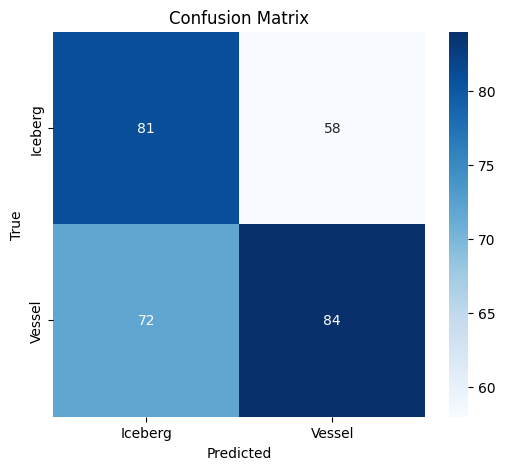

In [ ]:
best_model = tune_xgb_fast(df_ssf_swin, "label")

X = df_ssf_swin.drop(columns=["label"])
y = df_ssf_swin["label"]

# Split your data (example)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

metrics = evaluate_xgb_model(best_model, X_test, y_test)